# CNN Image Classification on CIFAR-10 (PyTorch)

In this project, I train a simple Convolutional Neural Network (CNN) with PyTorch on the CIFAR-10 dataset to classify natural images into 10 categories. The goal is to build an end-to-end deep learning pipeline (data loading, preprocessing, model, training loop, evaluation) and achieve a reasonable test accuracy with a small, easy-to-understand architecture.


## 1. Imports and Setup


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


## 2. Dataset and DataLoaders


In [ ]:
# Data transforms: normalization + simple augmentation for train
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

# Download CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train,
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test,
)

batch_size = 32 

subset_size = 10000  
indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = torch.utils.data.Subset(train_dataset, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

len(train_subset), len(test_dataset)

classes = train_dataset.classes
print("Classes:", classes)
len(train_dataset), len(test_dataset)


100.0%
C:\Users\Sokhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(50000, 10000)

### 2.1 Quick check on a training batch


In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Batch shape:", images.shape)
print("First 8 labels:", [classes[l] for l in labels[:8]])



Batch shape: torch.Size([32, 3, 32, 32])
First 8 labels: ['dog', 'ship', 'bird', 'horse', 'automobile', 'airplane', 'airplane', 'airplane']


## 3. CNN Model Architecture


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3x32x32 -> 32x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 32x32x32 -> 32x16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32x16x16 -> 64x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 64x16x16 -> 64x8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 64x8x8 -> 128x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # 128x8x8 -> 128x4x4
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=10).to(device)
print(model)


Using device: cpu
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


## 4. Training Setup (Loss, Optimizer, Hyperparameters)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 2  


Using device: cpu


## 5. Training Loop and Evaluation


In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [7]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"| Test loss: {test_loss:.4f}, acc: {test_acc:.4f}")


Epoch 1/2 - Train loss: 1.7339, acc: 0.3641 | Test loss: 1.4528, acc: 0.4755
Epoch 2/2 - Train loss: 1.3319, acc: 0.5177 | Test loss: 1.2734, acc: 0.5446


## 6. Results and Discussion

With a small CNN trained for 2 epochs on a 10,000-image subset of CIFAR-10, the model reaches approximately **52% training accuracy** and **54% test accuracy**. This is not optimized for maximum performance, but it demonstrates a complete end-to-end CNN pipeline in PyTorch (data loading, preprocessing, model definition, training loop, and evaluation) and shows that even a simple model can learn useful representations from limited data.


## 6. Results and Visualization


Epoch 1/2 - Train loss: 1.1311, acc: 0.5912 | Test loss: 1.1158, acc: 0.5995
Epoch 2/2 - Train loss: 0.9917, acc: 0.6466 | Test loss: 1.0624, acc: 0.6182


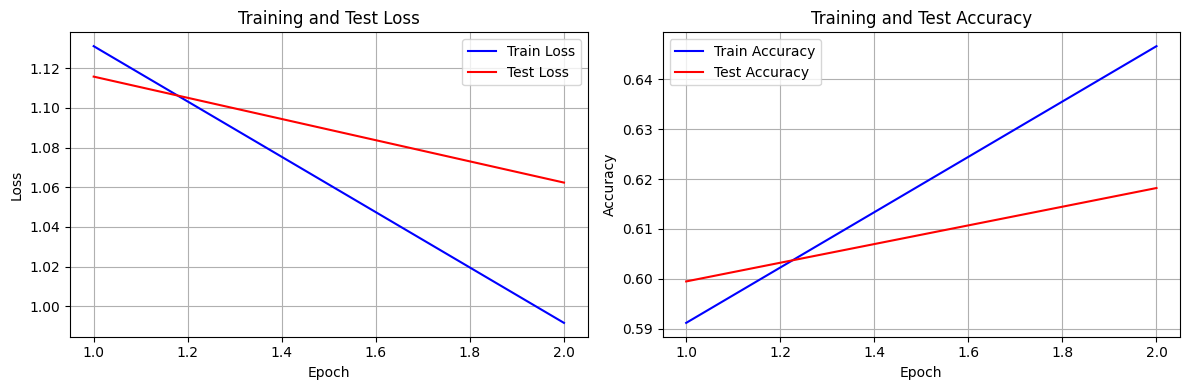

In [8]:
import matplotlib.pyplot as plt

# Initialize lists to track loss and accuracy metrics
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Re-train while tracking metrics
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# Visualize
epochs_list = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Train Loss')
plt.plot(epochs_list, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accs, 'b-', label='Train Accuracy')
plt.plot(epochs_list, test_accs, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.grid()

plt.tight_layout()
plt.show()
